# Deep Q-Learning - Car Racing

This project demonstrates the application of deep reinforcement learning, specifically the Deep Q-Network (DQN) algorithm, to train an agent to autonomously drive a car in the [Car Racing environment](https://gymnasium.farama.org/environments/box2d/car_racing/) from [gymnasium](https://gymnasium.farama.org/). The goal is to create an agent that can successfully navigate a randomly generated track, maximizing its reward by staying on the road and progressing forward, while avoiding penalties for leaving the track.

**Methods and Tools:**

*   **Deep Q-Network (DQN):** The core algorithm used to train the agent. DQN combines Q-learning with a deep neural network to approximate the optimal action-value function.
*   **Convolutional Neural Networks (CNNs):** The Q-network utilizes a CNN architecture. CNNs are particularly well-suited for processing image data, making them ideal for handling the visual input (pixel data) from the Car Racing environment. The CNN extracts relevant features from the raw pixel frames, such as track edges and car position.
*   **Experience Replay:** A technique where the agent stores its experiences (state, action, reward, next state, done) in a replay buffer (implemented as a `deque`).  This breaks correlations between consecutive experiences and allows the agent to learn from a diverse set of past interactions.
*   **Target Network:** A separate, slowly-updated neural network used to improve the stability of the learning process.  This network provides a more consistent target for the Q-value updates. Soft updates (`TAU`) are used to gradually update the target network's weights.
*   **ε-Greedy Exploration:** A strategy that balances exploration (taking random actions) and exploitation (taking actions based on the learned Q-values).  The exploration rate (`epsilon`) decays over time, shifting the agent's behavior from exploration to exploitation.
*   **Frame Stacking:**  Multiple consecutive frames of the game are stacked together to provide the agent with information about motion and velocity, which would be impossible to infer from a single frame.
*   **Image Preprocessing:** Raw pixel observations from the environment are preprocessed (grayscaling, cropping, resizing, and normalization) to reduce the dimensionality of the input and improve training efficiency.
*   **PyTorch:**  A popular deep learning framework used to implement the neural networks and training loop.
*   **Gymnasium:**  A standardized API for reinforcement learning environments, providing the CarRacing-v3 environment.
*   **NumPy:** Used for efficient numerical operations and array manipulation.
*   **Python Libraries:**  The project utilizes various Python libraries including `collections.deque` (for the replay buffer), `random` (for exploration), `PIL` (for image processing), `matplotlib` (for visualization), `imageio` (for video creation), and `base64` (for embedding videos in the notebook).

# Outline
- [ 1 - Project Packages <img align="Right" src="./images/car_racing.gif" width = 60% >](#1---Project-Packages)
- [ 2 - Hyperparameters](#2---Hyperparameters)
- [ 3 - The Car Racing Environment](#3---Car-Racing-Environment)
  - [ 3.1 - Action Space](#3.1---Action-Space)
  - [ 3.2 - Observation Space](#3.2---Observation-Space)
  - [ 3.3 - Rewards](#3.3---Rewards)
  - [ 3.4 - Episode Termination](#3.4---Episode-Termination)
- [ 4 - Environment Setup](#4---Environment-Setup)
- [ 5 - Interacting with the Gym Environment](#5---Interacting-With-The-Gym-Environment)
    - [ 5.1 - Exploring the Environment's Dynamics](#5.1---Exploring-The-Environment's-Dynamics)
- [ 6 - Deep Q-Learning](#6---Deep-Q-Learning)
  - [ 6.1 - Target Network](#6.1---Target-Network)
  - [ 6.2 - Image Preprocessing](#6.2---Image-Preprocessing)
  - [ 6.3 - Frame Stacking](#6.3---Frame-Stacking)
  - [ 6.4 - Deep Q-Network](#6.4---Deep-Q-Network)
  - [ 6.5 - Building The Q-Networks And Optimizer](#6.5---Building-The-Q-Networks-And-Optimizer)
  - [ 6.6 - Experience Replay](#6.6---Experience-Replay)
- [ 7 - Deep Q-Learning Algorithm with Experience Replay](#7---Deep-Q-Learning-Algorithm-With-Experience-Replay)
- [ 8 - Core DQN Functions](#8---Core-DQN-Functions)
- [ 9 - Train the Agent](#9---Train-The-Agent)
- [ 10 - See the Trained Agent In Action](#10---See-The-Trained-Agent-In-Action)

## 1 - Project Packages

**Core Python Libraries**

*   `time`: Provides time-related functions.  Used for measuring the total training time.
*   `collections`:  This module implements specialized container datatypes.
    *   `deque`:  A double-ended queue.  Crucially used for the `memory_buffer` (experience replay), allowing for efficient addition and removal of experiences from both ends.  This is much more efficient than using a standard Python list for this purpose.
    *   `namedtuple`:  Creates tuple-like objects with named fields.  We use it to define the `experience` tuple, making the code more readable (e.g., `exp.state` instead of `exp[0]`).
*   `random`: Implements pseudo-random number generators.  Essential for:
    *   Epsilon-greedy action selection (`random.random()` and `random.randrange()`).
    *   Sampling experiences from the replay buffer (`random.sample()`).

**Numerical Computing and Data Handling**

*   `numpy` (as `np`): The fundamental package for scientific computing in Python.  We use it for:
    *   Numerical operations on states (observations), rewards, etc.
        *   Efficient array manipulation.
        *   Preprocessing observations (cropping, resizing, grayscaling).
        *   Storing and handling experiences before converting to PyTorch tensors.

**Reinforcement Learning and Environment**

*   `gymnasium` (as `gym`):  A toolkit for developing and comparing reinforcement learning algorithms.  It's the successor to the older `gym` library from Open AI.  We use it to:
    *   Create the `CarRacing-v3` environment.
    *   Interact with the environment.
    *   Get information about the environment.

**Image Processing**

*   `PIL.Image`:  The Python Imaging Library (Pillow).  We use it for:
    *   Converting NumPy arrays to image objects.
    *   Resizing images during preprocessing.

**Deep Learning (PyTorch)**

*   `torch`: The main PyTorch library.  Provides tensors (multi-dimensional arrays similar to NumPy arrays) and automatic differentiation, which are essential for building and training neural networks.
*   `torch.nn` (as `nn`):  The neural network module in PyTorch.  We use it to define our DQN:
    *   `nn.Module`: The base class for all neural network modules.
    *   `nn.Conv2d`:  Convolutional layers for processing image data.
    *   `nn.Linear`:  Fully connected (linear) layers.
    *   `nn.ReLU`:  The Rectified Linear Unit activation function.
    *   `nn.Sequential`: For creating sequential models.
*   `torch.optim` (as `optim`):  Contains optimization algorithms.  We use `optim.Adam` for updating the weights of our DQN.
*   `torch.nn.functional` (as `F`):  Provides functions (often used within neural network definitions or loss calculations).  We use `F.mse_loss` to calculate the mean squared error loss.

**Visualization and Display**

*   `matplotlib.pyplot` (as `plt`): A plotting library used to visualize the preprocessed observations from the environment. We use this package to display the grayscale, cropped, and resized image and display the plot.
*   `IPython.display` (as `ipythondisplay`): Used to display a video of the environment's dynamics within a Jupyter Notebook.  Specifically, we use this package to embed an HTML video player that shows the recorded frames of the environment.
*   `imageio`: Used to create a video (MP4 file) of the environment's rendered frames.  `imageio.get_writer()` creates a video writer, and `video.append_data()` adds each rendered frame to the video.
*   `base64`: Used to encode the video data into a base64 string. This allows us to embed the video directly within the HTML, making it self-contained and portable within the Jupyter Notebook.

In [1]:
import os
import time
from collections import deque, namedtuple
import random
import numpy as np
import gymnasium as gym
import PIL.Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import imageio
import base64

**Note on headless servers**

Virtual displays, facilitated by libraries like `pyvirtualdisplay`, are essential when running graphical applications, such as reinforcement learning environments, on headless servers. These servers, lacking physical monitors, require a simulated display for rendering. This need arises in scenarios involving remote servers in cloud environments or data centers, where access is typically via SSH, or during automated testing and CI/CD pipelines. Essentially, any situation where graphical rendering is necessary on a system without a physical display necessitates the use of a virtual display to enable proper execution.

```python3
# Set up a virtual display to render the environment on a headless server.
# You may need these if working on a headless server
from pyvirtualdisplay import Display
Display(visible=0, size=(840, 480)).start();
```

## 2 - Hyperparameters

**Image Preprocessing Hyperparameters:**

*   `IMAGE_HEIGHT`:  The height (in pixels) of the preprocessed observation images after resizing.  This reduces the input dimensionality to the neural network, making training faster and less memory-intensive.
*   `IMAGE_WIDTH`: The width (in pixels) of the preprocessed observation images after resizing. Similar to `IMAGE_HEIGHT`, this reduces the input size. The aspect ratio is chosen to capture the relevant parts of the car's view.
*    `FRAME_STACK_SIZE`:  The number of consecutive preprocessed frames that are stacked together to form a single state.  This is crucial for capturing temporal information (motion) in the environment.  Instead of just seeing a single snapshot, the agent sees the last 4 frames, allowing it to infer velocity and direction.

**Reinforcement Learning Hyperparameters:**

*   `BATCH_SIZE`: The number of experiences sampled from the replay buffer (`memory_buffer`) during each training step.  Larger batch sizes generally lead to more stable training, but require more memory.  A batch size of 128 is a common choice, providing a good balance between stability and computational cost.
*   `GAMMA`: The discount factor. This determines the importance of future rewards relative to immediate rewards.  A value of 0.99 means that future rewards are highly valued, encouraging the agent to learn long-term strategies. A value closer to 0 would make the agent more short-sighted.
*   `EPS_START`: The initial value of epsilon for the epsilon-greedy exploration strategy.  At the beginning of training, the agent explores randomly (takes random actions) with a probability of EPS_START. This number is usually 1.0 (100%).
*   `EPS_END`: The minimum value of epsilon.  Even after extensive training, the agent will still explore randomly with a probability of EPS_END.  This ensures some ongoing exploration. This number is usually 0.01 (1%).
*   `EPS_DECAY`: The multiplicative factor by which epsilon is reduced after each episode. This gradually shifts the agent's behavior from exploration to exploitation.  The agent explores less and less over time, increasingly relying on its learned Q-values.
*   `TARGET_UPDATE_FREQ`:  How often (in terms of training steps) the target Q-network's weights are updated with the weights of the main Q-network.  Using a separate target network improves training stability by providing a more consistent target for the Q-value updates.  Updating it less frequently than the main network further enhances stability.
*   `MEMORY_SIZE`: The maximum capacity of the experience replay buffer (the `deque`).  This buffer stores past experiences (state, action, reward, next_state, done). A large buffer allows the agent to learn from a wider range of experiences and break correlations between consecutive experiences.
*   `LR`: The learning rate for the Adam optimizer. This controls how much the network's weights are adjusted during each training step.  A smaller learning rate generally leads to more stable, but slower, learning. 1e-4 is a common starting point for learning rates.
*   `NUM_EPISODES`: The total number of episodes the agent will be trained for.  An episode represents one complete run of the environment, from start to either success (reaching the target) or failure (crashing or timing out).
*   `TARGET_AVG_REWARD`: The average reward (over the last 100 episodes) that is considered "solving" the environment.  Once this threshold is reached, training can be stopped.
*   `PRINT_EVERY`: Controls how often training progress (episode number, average reward, epsilon, buffer size) is printed to the console. This helps monitor training.
*   `MAX_STEPS_PER_EPISODE`:  This limits the maximum number of steps the agent can take within a single episode.  This prevents episodes from running indefinitely if the agent gets stuck or learns a very inefficient policy.  It acts as a safety mechanism and helps manage training time.
*   `UPDATE_FREQ`: This determines how often (in environment *steps*) the agent performs a learning step (sampling a batch from the replay buffer and updating the Q-network).  An `UPDATE_FREQ` of 4 means the agent will learn after every 4 steps it takes in the environment.  This is a crucial parameter that controls how frequently the agent updates its policy based on new experiences. A smaller value means more frequent updates.
*  `TAU = 0.001`: The soft update parameter. Instead of directly copying the weights from the main Q-network to the target Q-network every `TARGET_UPDATE_FREQ` steps (a "hard" update), a "soft" update gradually blends the weights.  `TAU` controls the blending factor.  A small `TAU` (like 0.001) means the target network's weights are updated very slowly, incorporating only a small fraction of the main network's weights at each update. This significantly improves the stability of training.  The update rule is:  `target_weights = (1 - TAU) * target_weights + TAU * main_weights`.

In [2]:
IMAGE_HEIGHT = 36
IMAGE_WIDTH = 36
FRAME_STACK_SIZE = 4
BATCH_SIZE = 256
GAMMA = 0.995
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.99
TARGET_UPDATE_FREQ = 1000
MEMORY_SIZE = 1_000_000
LR = 0.001
NUM_EPISODES = 10_000
TARGET_AVG_REWARD = 900
PRINT_EVERY = 50
MAX_STEPS_PER_EPISODE = 1000
UPDATE_FREQ = 4
TAU = 0.001

## 3 - Car Racing Environment

The goal of the CarRacing-v3 environment is to control a car on a randomly generated race track.  Unlike a real race, the objective isn't necessarily to finish laps, but rather to visit as many track tiles as possible.  The environment provides a top-down, pixel-based view of the car and track.

<br>
<br>
<figure>
  <img src = "images/car_racing.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Fig 1. Car Racing Environment.</figcaption>
</figure>

### 3.1 - Action Space

The agent chooses one of five discrete actions:

* Do nothing.
* Steer left.
* Steer right.
* Gas.
* Break.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Steer right = 1
Steer left = 2
Gas = 3
Break = 4
```
### 3.2 - Observation Space

Box(0, 255, (96, 96, 3), uint8):  A 96x96 pixel RGB image representing the top-down view of the car and the track. The agent learns directly from these pixel observations.

### 3.3 - Rewards

* -0.1 reward per frame (time step): Encourages efficiency.
* +1000/N reward for each track tile visited (where N is the total number of tiles on the track): This is the primary reward, promoting track exploration.
* -100 reward for going off-track (ends the episode).

 For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points

### 3.4 - Episode Termination

The episode finishes when all of the tiles are visited. The car can also go outside of the playfield - that is, far off the track, in which case it will receive -100 reward and die.

## 4 - Environment Setup

The following code sets up the CarRacing environment with specific parameters controlling rendering, success conditions, randomization, and the type of action space.  It then retrieves and prints important information about the environment: the shape of the observations and the number of available actions. These values are needed for configuring the DQN (e.g., the input and output dimensions of the neural network). Using a discrete action space and *not* using domain randomization significantly simplifies the problem compared to a continuous, randomized environment.

*   `env = gym.make("CarRacing-v3", ...)`: This line creates an instance of the `CarRacing-v3` environment using the `gymnasium` library.  `gym.make()` is the core function for instantiating environments. Let's look at the arguments:
    *   `"CarRacing-v3"`: This is the string identifier for the specific environment we are using.  `CarRacing-v3` is the most recent version of the `CarRacing` environment in `gymnasium` at the moment.
    *   `render_mode="rgb_array"`: This specifies how the environment will be rendered.  `"rgb_array"` means that calling `env.render()` will return a NumPy array representing the RGB image of the current state of the game. This is essential for creating videos and for visual debugging.  Other render modes might include `"human"` (for displaying the game in a window) or `"ansi"` (for text-based representations).
    *   `lap_complete_percent=0.95`: This is a *custom* parameter specific to this `CarRacing` implementation.  It determines what percentage of the track needs to be completed for the episode to be considered a "success".  Setting it to 0.95 means the agent doesn't need to complete a *full* lap, but 95% of it, to get the maximum reward.  This can make training easier.
    *   `domain_randomize=False`:  Domain randomization is a technique used to make agents more robust to changes in the environment. If set to `True`, the environment's appearance (e.g., colors, textures) would be randomly modified during training.  Setting it to `False` keeps the environment's appearance consistent, which is simpler for initial training.
    *   `continuous=False`: This is a *very* important setting. It determines whether the action space is continuous or discrete.
        *   `continuous=True`:  The agent would output continuous values for steering, acceleration, and braking (e.g., steering angle between -1 and 1, acceleration between 0 and 1).
        *   `continuous=False`: The agent chooses from a *discrete* set of predefined actions. We use the discrete action space, which is significantly easier to handle with DQN.
*  `state_size = env.observation_space.shape`: gets the dimensions of the observations. The observations returned by the default `CarRacing-v3` are arrays of the dimensions (96, 96, 3).
* `num_actions = env.action_space.n`: This line retrieves the number of *discrete* actions available in the environment. Because `continuous=False`, the action space is discrete, and `env.action_space.n` gives the total count of these actions.

In [3]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=False)
state_size = env.observation_space.shape
num_actions = env.action_space.n
print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (96, 96, 3)
Number of actions: 5


Once we load the environment we use the `.reset()` method to reset the environment to the initial state. The car starts at the beginning of the track in the environment and we can render the first frame of the environment by using the `.render()` method. There is an animation that zooms from high in the sky looking at the whole track into the car at the start of the game. To see the zoomed in view we will use for training, we render the 50th frame.

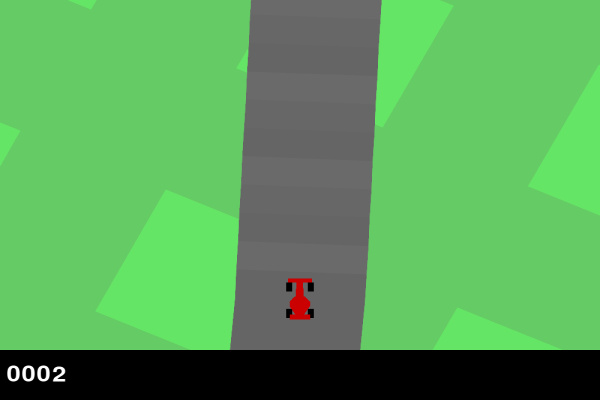

In [4]:
env.reset()
for i in range(50):
    action = 0 # Do nothing.
    env.step(action)
PIL.Image.fromarray(env.render())

## 5 - Interacting With The Gym Environment

The Gym library implements the standard “agent-environment loop” formalism:

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 2. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps $t=0,1,2,...$. At each time step $t$, the agent uses a policy $\pi$ to select an action $A_t$ based on its observation of the environment's state $S_t$. The agent receives a numerical reward $R_t$ and on the next time step, moves to a new state $S_{t+1}$.

### 5.1 - Exploring The Environment's Dynamics

In gym environments, we use the `.step()` method to run a single time step of the environment's dynamics. In the version of `gym` that we are using the `.step()` method accepts an action and returns five values:

* `observation` (**object**): an environment-specific object representing your observation of the environment. In the Car Racing environment this corresponds to a numpy array containing the pixels of the image of the car and the race track. [3.2 Observation Space](#3.2).

* `reward` (**float**): amount of reward returned as a result of taking the given action. In the Lunar Lander environment this corresponds to a float of type `numpy.float64` as described in section [3.3 Rewards](#3.3).

* `terminated` (**boolean**): When terminated is `True`, it indicates that the agent reaches the terminal state (as defined under the MDP of the task) which can be positive or negative.

* `truncated` (**boolean**): When truncated is `True`, it indicates that a condition outside the scope of the MDP is satisfied. Typically, this is a timelimit, but could also be used to indicate an agent physically going out of bounds. Can be used to end the episode prematurely before a terminal state is reached. If true, the user needs to call reset().

* `info` (**dictionary**): diagnostic information useful for debugging. We won't be using this variable in this notebook but it is shown here for completeness.

To begin an episode, we need to reset the environment to an initial state. We do this by using the `.reset()` method. 

In [5]:
# Reset the environment and get the initial state.
current_state = env.reset()

Once the environment is reset, the agent can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below we can select different actions and see how environment is updated depending on the action taken. Remember that in this environment the agent has five discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Steer right = 1
Steer left = 2
Gas = 3
Break = 4
```

Let's demonstrate how we can use the different action to do doughnuts in the race track.

In [6]:
filename = "./videos/env_dynamics.mp4"
with imageio.get_writer(filename, fps=30) as video:
    frame= env.render()
    video.append_data(frame)
    # Let's go forward for 5 seconds
    for _ in range(150):
        env.step(3)
        frame = env.render()
        video.append_data(frame)
    # Let's go left and press gas for 4 seconds
    for _ in range(120):
        env.step(2)
        frame = env.render()
        video.append_data(frame)
    # Let's go forward for 3 seconds
    for _ in range(90):
        env.step(3)
        frame = env.render()
        video.append_data(frame)
    # Break!
    for _ in range(60):
        env.step(4)
        frame = env.render()
        video.append_data(frame)
video = open(filename, "rb").read()
b64 = base64.b64encode(video)
tag = """
<br>
<br>
<video width="840" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4">
Your browser does not support the video tag.
</video>""".format(
    b64.decode()
)

ipythondisplay.HTML(tag)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***.

### 6.1 - Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

This forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights of the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

<a name="6.2"></a>
### 6.2 - Image Preprocessing

To improve training stability and efficiency, we preprocess the raw observations (96x96x3 RGB images) before using them as input to the Q-network.  The `preprocess` function performs the following steps:

1.  **Grayscale Conversion:** Converts the image to grayscale using standard luminosity weights. This reduces the input dimensionality.
2.  **Cropping:** Crops the image, removing irrelevant regions from the left, right, and bottom.  This focuses the agent on the essential parts of the scene.
3.  **Resizing:** Resizes the cropped image to 48x24. This further reduces the input size, speeding up computation.
4.  **Normalization:** Normalizes the pixel values to the range [0, 1]. This improves training stability.

Below you can see what the preprocessed image looks like.

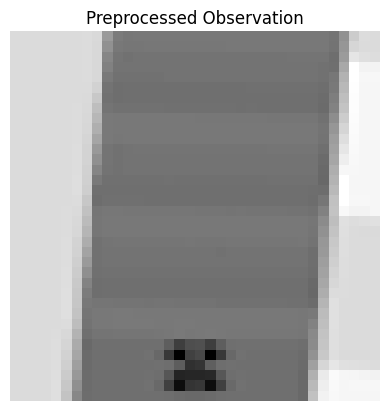

In [7]:
obs, _ = env.reset()

# Preprocessing function
def preprocess(obs):
    obs = np.dot(obs[..., :3], [0.299, 0.587, 0.114])  # Grayscale
    obs = obs[:79, 32:64]  # Crop
    obs = PIL.Image.fromarray(obs).resize((IMAGE_WIDTH, IMAGE_HEIGHT)) # Resize
    obs = np.array(obs, dtype=np.float32) / 255.0  # Normalize AND ensure float32
    return obs

# --- Process and Visualize a Single Image ---
for _ in range(50):
    obs, _, _, _, _ = env.step(0) # Do nothing.

processed_obs = preprocess(obs)
plt.imshow(processed_obs, cmap='gray')
plt.title("Preprocessed Observation")
plt.axis('off')
plt.show()

### 6.3 - Frame Stacking

A single frame from the Car Racing environment doesn't provide the agent with information about the car's velocity or direction.  To give the agent a sense of motion, we use a technique called **frame stacking**.  This involves combining multiple consecutive frames into a single state representation.

In this project, we use `FRAME_STACK_SIZE = 4`, meaning that each state consists of the 4 most recent preprocessed frames.  This allows the convolutional neural network to learn not just spatial features (what's in the image), but also *temporal* features (how things are changing over time).

We use a `collections.deque` (double-ended queue) to efficiently manage the frame stack.  A `deque` is ideal because it has a fixed maximum length (`maxlen`).  When a new frame is added to a full `deque`, the oldest frame is automatically removed.

Here's the code for frame stacking, along with a visualization of the initial stacked state:


Shape of a single preprocessed frame: (36, 36)
Shape of the initial stacked state: (36, 36, 4)


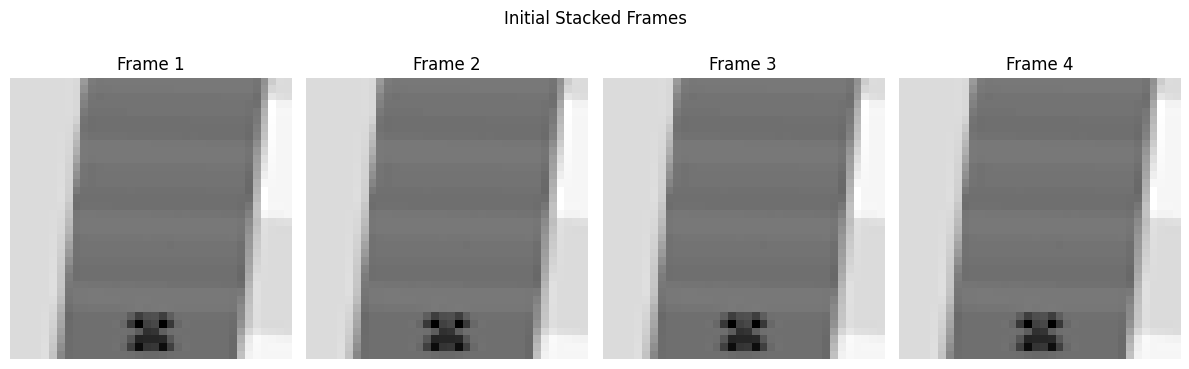

In [8]:
# Create the deque with a maximum length of FRAME_STACK_SIZE
frames = deque(maxlen=FRAME_STACK_SIZE)

# Preprocess the initial observation
processed_obs = preprocess(obs)

# Initialize the deque with the *same* preprocessed frame, repeated FRAME_STACK_SIZE times.
# This is necessary because at the beginning of an episode, there are no previous frames.
for _ in range(FRAME_STACK_SIZE):
    frames.append(processed_obs)

# Stack the frames along the *last* axis to create the initial state.
initial_state = np.stack(frames, axis=-1)

print(f"Shape of a single preprocessed frame: {processed_obs.shape}")  # (IMAGE_HEIGHT, IMAGE_WIDTH)
print(f"Shape of the initial stacked state: {initial_state.shape}")  # (IMAGE_HEIGHT, IMAGE_WIDTH, FRAME_STACK_SIZE)

# --- Visualization ---
# Display each frame in the initial state
fig, axes = plt.subplots(1, FRAME_STACK_SIZE, figsize=(12, 4))  # Create subplots
fig.suptitle("Initial Stacked Frames")

for i in range(FRAME_STACK_SIZE):
    axes[i].imshow(initial_state[:, :, i], cmap='gray')  # Display each frame
    axes[i].set_title(f"Frame {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 6.4 - Deep Q-Network

In Deep Q-Learning, we use a neural network to approximate the optimal action-value function,  `Q*(s, a)`. This neural network is called the Q-network.  In this section, we define a `DQN` class using PyTorch to represent this Q-network.  This class encapsulates the network's architecture, forward pass, and helper functions.

**Why Create a `DQN` Class and Inherit from `nn.Module`?**

*   **Organization and Reusability:** Creating a class provides a structured way to organize the code related to the Q-network.  It makes the code more readable, maintainable, and reusable.  You can easily create multiple instances of the `DQN` class (e.g., one for the online network and one for the target network).
*   **`nn.Module` Base Class:**  `nn.Module` is the base class for *all* neural network modules in PyTorch.  Inheriting from `nn.Module` provides several benefits:
    *   **Automatic Tracking of Parameters:** `nn.Module` automatically tracks all the learnable parameters (weights and biases) of your network. This is essential for training. You can access these parameters using `model.parameters()`, which is used by the optimizer.
    *   **`to(device)` Method:** `nn.Module` provides methods like `to(device)` that allow you to easily move the entire network (all its parameters) to the CPU or GPU.
    *   **`train()` and `eval()` Modes:** `nn.Module` allows you to switch between training mode (`model.train()`) and evaluation mode (`model.eval()`).  This is important for layers like batch normalization and dropout, which behave differently during training and evaluation.
    *   **Layer Management:** `nn.Module` makes it easy to define and manage layers (like convolutional layers, linear layers, etc.) within your network.

**Network Architecture:**

The `DQN` class defines a convolutional neural network (CNN) with the following architecture:

1.  **Convolutional Layers (`self.conv`):**
    *   `nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)`: The first convolutional layer takes the stacked frames (with `input_channels` channels) as input.  It has 32 filters, an 8x8 kernel, and a stride of 4.
    *   `nn.ReLU()`:  A ReLU (Rectified Linear Unit) activation function is applied after each convolutional layer.  ReLU introduces non-linearity, allowing the network to learn complex patterns.
    *   `nn.Conv2d(32, 64, kernel_size=4, stride=2)`: The second convolutional layer.
    *   `nn.Conv2d(64, 64, kernel_size=3, stride=1)`: The third convolutional layer.
    *   These convolutional layers extract features from the input image stack.  The kernel size, stride, and number of filters are hyperparameters that can be tuned.

2.  **Fully Connected Layers (`self.fc`):**
    *   `nn.Linear(conv_out_size, 512)`: The first fully connected (dense) layer.  It takes the *flattened* output from the convolutional layers as input. `conv_out_size` is the number of input features to this layer (calculated by `_get_conv_out`).  It has 512 output units.
    *   `nn.ReLU()`: ReLU activation.
    *   `nn.Linear(512, num_actions)`: The output layer.  It has `num_actions` output units, one for each possible action.  The output of this layer represents the Q-values for each action in the given state.

**Why Calculate the Output Size (`_get_conv_out`)?**

*   **Connecting Convolutional and Fully Connected Layers:** The output of the convolutional layers is a multi-dimensional tensor (height x width x channels).  The fully connected layers expect a 1D vector as input.  Therefore, we need to *flatten* the output of the convolutional layers before passing it to the fully connected layers.
*   **Dynamic Calculation:** The `_get_conv_out` function calculates the size of this flattened output *dynamically*.  This is important because the output size depends on the input image dimensions, the number of convolutional layers, their kernel sizes, and their strides.  Instead of manually calculating the size, we use a "dummy" input to let the network itself determine the output size.
* **How `_get_conv_out` works:**
   *  `dummy_input = torch.zeros(1, input_channels, IMAGE_HEIGHT, IMAGE_WIDTH)` creates a tensor filled with zeros, representing a single input sample with the appropriate input shape to the network.
   *   `o = self.conv(dummy_input)` passes this dummy input *through the convolutional layers only*.
   *  `return int(np.prod(o.size()))` calculates the total number of elements in the output tensor `o` (which is the flattened size) and returns it as an integer.

**`self.fc`:**

*   `self.fc` is an attribute of the `DQN` class that holds the *fully connected* layers of the network (defined using `nn.Sequential`).  It's used in the `forward` method to process the flattened output of the convolutional layers.

**`forward(self, x)` Method:**

*   The `forward` method defines how data flows through the network (the forward pass).  It's called when you pass an input to the network (e.g., `q_network(state)`).
    *   **`conv_out = self.conv(x).view(x.size()[0], -1)`:**
        *   `self.conv(x)`: Passes the input `x` (the stacked frames) through the convolutional layers.
        *   `.view(x.size()[0], -1)`: Flattens the output of the convolutional layers.
            *   `x.size()[0]`: Gets the batch size.
            *   `-1`:  Infers the remaining dimension (the flattened size).
    *   **`return self.fc(conv_out)`:** Passes the flattened output (`conv_out`) through the fully connected layers (`self.fc`) and returns the final output (the Q-values).


In [9]:
class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Calculate output size dynamically
        dummy_input = torch.zeros(1, input_channels, IMAGE_HEIGHT, IMAGE_WIDTH)
        conv_out_size = self._get_conv_out(dummy_input)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, input_tensor):
        o = self.conv(input_tensor)
        return int(np.prod(o.size()))

    def forward(self, x):
        # Input should already be (Batch, Channels, Height, Width)
        conv_out = self.conv(x).reshape(x.size(0), -1)  # Flatten
        return self.fc(conv_out)

### 6.5 - Building The Q-Networks And Optimizer

In this section, we create instances of our `DQN` class to represent the online Q-network and the target Q-network. We also set up the optimizer and configure the device (CPU or GPU) for training. We accomplish this by:

1. Setting the `input_channels` variable to the value of `FRAME_STACK_SIZE` which is 4 in our case. The variable determines the number of input channels for the first convolutional layer of the DQN network representing our stacked frames.
2. Creating an instance of the DQN class that will represent the q_netowrk. This is our online Q-network which we will actively train. We pass `input_channels` and `num_actions` to the DQN constructor.
3. Creating another instance of the DQN class that will represent our target q-network. I thas the same architecture as the online network.
4. We initialize the weights of the target network with the same weights as the online network. `q_network.state_dict()` returns a dictonary containing all the weights and biases of the online network. `target_q_network.load_state_dict(...)` loads these parameters into the target network.
5. Putting the target network into evaluation mode. In evaluation mode, certain layers behave differently than in training mode. For the target network, we always want it to be in evaluation mode because we are not training it directly, we are only using it to generate target Q-values.
6. Creating an Adam optimizer. Adamis a popular optmization algorithm used for training neural networks. `q_network.parameters()` provides the optmizer with the parameters of the online Q-network. The optmizer will update only these parameters during training. Thetarget nework's parameters are not directly updated by the optimizer. `lr=RL` sets the learning rate of the optimizer.

We also try to use the GPU if its available, and finally we display the structure of the q_network.

In [10]:
# Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")  # Verify it's using MPS

# Networks and Optimizer
q_network = DQN(FRAME_STACK_SIZE, num_actions).to(device)
target_q_network = DQN(FRAME_STACK_SIZE, num_actions).to(device)
target_q_network.load_state_dict(q_network.state_dict())
target_q_network.eval()
optimizer = optim.Adam(q_network.parameters(), lr=LR)

print(q_network)
env.close()

Using device: mps
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)


### 6.6 - Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn directly from these consecutive experiences, it can run into problems due to the strong correlations between them.  This can lead to unstable learning and poor generalization.

To avoid this, we employ a technique known as **Experience Replay**, which is a cornerstone of off-policy reinforcement learning algorithms like DQN. Experience Replay addresses these issues by:

1.  **Breaking Correlations:** Randomly sampling experiences breaks the temporal correlations present in sequential interactions.
2.  **Improving Sample Efficiency:**  Experiences are stored and reused multiple times, allowing the agent to learn more from each interaction.
3.  **Enabling Off-Policy Learning:** The agent can learn from experiences generated by previous policies.

**Implementation:**

Experience replay consists of storing the agent's experiences in a memory buffer (often called a replay buffer) and then sampling a random mini-batch of experiences from this buffer during training.  The experience tuples $(S_t, A_t, R_t, S_{t+1}, D_t)$ are added to the memory buffer at each time step:

*   $S_t$: The state at time step *t*.
*   $A_t$: The action taken at time step *t*.
*   $R_t$: The reward received at time step *t*.
*   $S_{t+1}$: The next state (the state resulting from taking action $A_t$ in state $S_t$).
* $D_t$: *terminated* or *truncated*.

For convenience and readability, we will store these experiences as named tuples.

In [11]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

<a name="7"></a>
## 7 - Deep Q-Learning Algorithm With Experience Replay

Now that we have the Q-network, target network, and preprocessing steps defined, we can implement the core logic for calculating the loss used to train the Q-network.  This loss is based on the Temporal Difference (TD) error, derived from the Bellman equation.

The `compute_loss` function, defined below, takes a batch of experiences from the replay buffer and calculates the MSE loss between the predicted Q-values and the target Q-values.

**Target Q-Value Calculation:**

The target Q-value (`y_j`) for each experience in the batch is calculated as follows:

$$
\begin{equation}
  y_j =
  \begin{cases}
    R_j & \text{if episode terminates at step } j+1 \\
    R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a'; w^-) & \text{otherwise} \\
  \end{cases}
\end{equation}
$$

Where:

*   $R_j$: The reward received for the experience.
*   $\gamma$: The discount factor.
*   $\hat{Q}(s_{j+1}, a'; w^-)$: The maximum Q-value predicted by the *target* network for the next state ($s_{j+1}$), considering all possible actions ($a'$).
*   $w^-$: The weights of the *target* network.

The `done` value in the experience tuple is used to determine whether the episode terminated.  If `done` is `True` (1), the target is simply the reward.  If `done` is `False` (0), the target includes the discounted maximum Q-value from the next state.

**Loss Calculation:**

The loss is the Mean-Squared Error (MSE) between the calculated target Q-values (`y_targets`) and the Q-values predicted by the *online* Q-network (`q_network`) for the actions that were actually taken in the given states.

In [12]:
# Loss Function (Corrected Unpacking and Permutation)
def compute_loss(experiences, gamma, q_network, target_q_network, device):
    """
    Calculates the loss.

    Args:
        experiences: (list) List of "Experience" namedtuples
        gamma: (float) The discount factor.
        q_network: (DQN) PyTorch model.
        target_q_network: (DQN) PyTorch model.
        device: (torch.device)

    Returns:
        loss: (torch.Tensor) the Mean-Squared Error.
    """

    # Unpack using list comprehensions
    states = np.array([exp.state for exp in experiences])
    actions = np.array([exp.action for exp in experiences])
    rewards = np.array([exp.reward for exp in experiences])
    next_states = np.array([exp.next_state for exp in experiences])
    done_vals = np.array([exp.done for exp in experiences])

    # Convert to PyTorch tensors, move to device, AND PERMUTE
    states = torch.tensor(states, dtype=torch.float32).to(device)
    states = states.permute(0, 3, 1, 2)  # (B, C, H, W)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    next_states = next_states.permute(0, 3, 1, 2)  # (B, C, H, W)  <-- CRITICAL FIX
    done_vals = torch.tensor(done_vals, dtype=torch.float32).to(device)

    # Compute max Q^(s',a') for *next* states using *target* network
    with torch.no_grad():
        next_q_values = target_q_network(next_states)
        max_next_qsa = torch.max(next_q_values, dim=1)[0]

    # Calculate y_targets (Bellman equation)
    y_targets = rewards + (gamma * max_next_qsa * (1 - done_vals))

    # Get Q-values for the actions taken
    q_values = q_network(states)
    predicted_q_values = torch.gather(q_values, 1, actions.unsqueeze(1)).squeeze(1)

    # Compute the loss (Mean-Squared Error)
    loss = F.mse_loss(y_targets, predicted_q_values)

    return loss

## 8 - Core DQN Functions

`get_action` - **Epsilon-Greedy Action Selection**
The get_action function implements an epsilon-greedy policy to select an action for the agent. This balances exploration (choosing random actions) with exploitation (choosing the action believed to be best according to the current Q-values).

`update_target_network` - **Soft Target Network Update**
The update_target_network function performs a soft update of the target Q-network's weights. This helps to stabilize training by preventing large, abrupt changes in the target Q-values. The target network's weights are gradually adjusted towards the online network's weights using a parameter TAU.

`agent_learn` - **Agent Learning Step (DQN Update)**
The agent_learn function performs a single step of the Deep Q-Network (DQN) training process. It takes a batch of experiences, calculates the loss, updates the online Q-network's weights using gradient descent, and performs a soft update of the target Q-network.

In [13]:
# Epsilon-Greedy
def get_action(q_values, epsilon, num_actions, device):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    else:
        return torch.argmax(q_values).item()  # No need for .cpu() here

# Target Network Update
def update_target_network(q_network, target_q_network):
    for target_param, q_param in zip(target_q_network.parameters(), q_network.parameters()):
        target_param.data.copy_(TAU * q_param.data + (1.0 - TAU) * target_param.data)

# Agent Learning Step
def agent_learn(experiences, gamma, q_network, target_q_network, optimizer, device):
    loss = compute_loss(experiences, gamma, q_network, target_q_network, device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    update_target_network(q_network, target_q_network)

## 9 - Train The Agent

**Algorithm Steps:**

1.  **Initialization:**
    *   Initialize a replay buffer (`memory_buffer`) of size `MEMORY_SIZE`.
    *   Initialize the online Q-network (`q_network`) and target Q-network (`target_q_network`).  The target network starts with the same weights as the online network.
    *   Set the initial exploration rate (`epsilon = EPS_START`).
    *   Initialize an empty list (`total_rewards_history`) to store episode rewards.
    * Record start time.

2.  **Episode Loop:** Iterate for `NUM_EPISODES` episodes.

    *   **Environment Reset:** Reset the environment (`env.reset()`) and preprocess the initial observation to get the starting `state`. Initialize total reward for the episode.
    *   **Frame Stacking Initialization:** Initialize a `deque` (`frames`) to store the last `FRAME_STACK_SIZE` preprocessed frames, and fill it with initial state.
    *   **Timestep Loop:** Iterate for up to `MAX_STEPS_PER_EPISODE` timesteps.
        *   **State Preparation:** Convert `state` to PyTorch tensor, add batch dimension, move to device, and permute to (B, C, H, W) format.
        *   **Action Selection:** With `torch.no_grad()`, get Q-values from `q_network`. Choose an action using an ε-greedy policy:
            *   With probability `epsilon`, choose a random action.
            *   With probability `1 - epsilon`, choose the action that maximizes the Q-value.
        *   **Environment Step:** Take the chosen action in the environment (`env.step(action)`) and receive `next_obs`, `reward`, `terminated`, `truncated`, and info (discarded).
        *   **Preprocessing and Frame Stacking:** Preprocess `next_obs`, append to `frames` (automatically removing oldest frame), and create `next_state` by stacking frames.
        *   **Store Experience:** Store the experience tuple (`state`, `action`, `reward`, `next_state`, `done`) in `memory_buffer`.
        *   **Learning Update:**
            *   Check if enough experiences are in `memory_buffer` AND if `step` is a multiple of `UPDATE_FREQ`.
            *   If both are true:
                *   Sample a mini-batch of `BATCH_SIZE` experiences from `memory_buffer`.
                *   Call `agent_learn` to calculate the loss and update `q_network` weights using the optimizer, and soft-update `target_q_network` weights.
        *  **Target Network Update**
            *   Check if `step` is a multiple of `TARGET_UPDATE_FREQ`.
            *   If true: Call `update_target_network` to soft update target network.
        *   **Update State:** Set `state = next_state`.
        *   **Reward Update:** `total_reward` increase by current `reward`
        *   **Episode Termination:** If `terminated` or `truncated` is `True`, break the timestep loop.

    *   **Epsilon Decay:** Decrease `epsilon` (but not below `EPS_END`) after each episode.
    *   **Progress Tracking and Early Stopping:**
        * Store episode's total reward.
        * Calculate the average reward over the last 100 episodes.
        * Print progress every `PRINT_EVERY` episodes.
        * If the average reward reaches `TARGET_AVG_REWARD`, save the `q_network` weights and stop training.
3. **End:** Close environment and print total training time.

In [14]:
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Training Loop
epsilon = EPS_START
total_rewards_history = []
start_time = time.time()
best_avg_reward = -float('inf')  # Initialize with negative infinity
best_model_path = ""
SAVE_EVERY=10

# if not os.path.exists("saved_models"):
#     os.makedirs("saved_models")

# # Check for existing models
# existing_models = [f for f in os.listdir("saved_models") if f.endswith(".pth")]

# if existing_models:
#     # Sort models by reward (assuming filename format: car_racing_{reward}.pth)
#     existing_models.sort(key=lambda x: int(x.split("_")[2].split(".")[0]), reverse=True)
#     best_model_path = os.path.join("saved_models", existing_models[0])
#     print(f"Loading pre-trained model from: {best_model_path}")
#     q_network.load_state_dict(torch.load(best_model_path, map_location=device))
#     q_network.to(device)
#     target_q_network.load_state_dict(q_network.state_dict())
#     target_q_network.to(device)
#     target_q_network.eval()  # Put target network in eval mode
#     # Extract the best average reward from the filename
#     best_avg_reward = int(existing_models[0].split("_")[2].split(".")[0])
#     print(f"Pre-trained model loaded with best average reward: {best_avg_reward}")
#     # epsilon = 0.044
#     # print(f"Epsilon: {epsilon}")
# else:
#     print("No pre-trained model found. Starting from scratch.")

for episode in range(1, NUM_EPISODES + 1):
    state, _ = env.reset()
    state = preprocess(state)
    frames = deque(maxlen=FRAME_STACK_SIZE)
    for _ in range(FRAME_STACK_SIZE):
        frames.append(state)
    state = np.stack(frames, axis=-1)  # Stack along the LAST axis
    total_reward = 0

    for step in range(1, MAX_STEPS_PER_EPISODE + 1):
        # To device, unsqueeze, permute
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        state_tensor = state_tensor.permute(0, 3, 1, 2)  # (B, C, H, W)

        with torch.no_grad():
            q_values = q_network(state_tensor)
        action = get_action(q_values, epsilon, num_actions, device)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = preprocess(next_obs)
        frames.append(next_state)
        next_state = np.stack(frames, axis=-1)
        done = terminated or truncated

        # Store experience (store the UNTRANSPOSED next_state)
        exp = experience(state, action, reward, next_state, done)
        memory_buffer.append(exp)

        if len(memory_buffer) >= BATCH_SIZE and step % UPDATE_FREQ == 0:
            experiences = random.sample(memory_buffer, k=BATCH_SIZE)
            agent_learn(experiences, GAMMA, q_network, target_q_network, optimizer, device)

        if step % TARGET_UPDATE_FREQ == 0:
            update_target_network(q_network, target_q_network)

        total_reward += reward
        state = next_state  # No transpose needed here

        if done:
            break

    total_rewards_history.append(total_reward)
    average_reward = np.mean(total_rewards_history[-100:])
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    if episode % PRINT_EVERY == 0:
        print(f"Episode: {episode}/{NUM_EPISODES}, Average Reward: {average_reward:.2f}, Epsilon: {epsilon:.3f}, Buffer size: {len(memory_buffer)}")

    # if average_reward > best_avg_reward:
    #     best_avg_reward = average_reward
    #     # Save the model with the average reward in the filename
    #     model_path = os.path.join("saved_models", f"car_racing_{int(best_avg_reward)}.pth")
    #     torch.save(q_network.state_dict(), model_path)
    #     print(f"New best model saved to {model_path} (Avg Reward: {best_avg_reward:.2f})")
    #     best_model_path = model_path  # Keep track of the best model's path

    # # Check if the average reward has dropped significantly
    # if average_reward < 0.8 * best_avg_reward:
    #     print(f"Performance dropped! Reloading best model from: {best_model_path}")
    #     # 1. Reload best model
    #     q_network.load_state_dict(torch.load(best_model_path, map_location=device))
    #     q_network.to(device)  # Ensure it's on the correct device
    #     target_q_network.load_state_dict(q_network.state_dict()) # update target network
    #     target_q_network.to(device)
    #     target_q_network.eval() # put target network in eval mode.

    #     # 2. Increase exploration (if not already high)
    #     if epsilon < 0.20:
    #         epsilon = 0.50
    #         print("Increased epsilon to 0.50")
    # Save the model every SAVE_EVERY episodes
    if episode % SAVE_EVERY == 0:
        model_path = os.path.join("saved_models", f"car_racing_model_episode_{episode}.pth")
        torch.save(q_network.state_dict(), model_path)
        # print(f"Model saved to {model_path}")
    
    if average_reward >= TARGET_AVG_REWARD:
        print(f"Environment solved in {episode} episodes! Average Reward: {average_reward:.2f}")
        torch.save(q_network.state_dict(), 'car_racing_model.pth')
        break

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")
env.close()

Episode: 50/10000, Average Reward: -49.79, Epsilon: 0.605, Buffer size: 50000
Episode: 100/10000, Average Reward: -36.58, Epsilon: 0.366, Buffer size: 100000
Episode: 150/10000, Average Reward: -14.19, Epsilon: 0.221, Buffer size: 150000
Episode: 200/10000, Average Reward: -2.74, Epsilon: 0.134, Buffer size: 199603
Episode: 250/10000, Average Reward: -4.19, Epsilon: 0.081, Buffer size: 249603
Episode: 300/10000, Average Reward: -11.07, Epsilon: 0.049, Buffer size: 299424
Episode: 350/10000, Average Reward: 1.69, Epsilon: 0.030, Buffer size: 349424
Episode: 400/10000, Average Reward: 38.62, Epsilon: 0.018, Buffer size: 399424
Episode: 450/10000, Average Reward: 93.71, Epsilon: 0.011, Buffer size: 449424
Episode: 500/10000, Average Reward: 156.94, Epsilon: 0.010, Buffer size: 499424
Episode: 550/10000, Average Reward: 220.27, Epsilon: 0.010, Buffer size: 549424
Episode: 600/10000, Average Reward: 274.12, Epsilon: 0.010, Buffer size: 599424
Episode: 650/10000, Average Reward: 289.81, Epsi

KeyboardInterrupt: 

## 10 - See The Trained Agent In Action

Now that we have trained our agent, we can see it in action. We will use the `create_video` function to create a video of our agent interacting with the `CarRacing-v3` environment using the trained Q-Network. The `create_video` function uses the `imageio` library to create the video. This library may produce some warnings that can be distracting; to suppress these, we've included code to filter deprecation warnings at the beginning of the notebook.

In the cell below, we create a video of our agent interacting with the `CarRacing-v3` environment using the trained `q_network`.  The video is saved to the `videos` folder with the given `filename`.  We use the `embed_mp4` function to embed the video in the Jupyter Notebook so that we can see it directly without having to download it.

Since the `CarRacing-v3` environment has some inherent randomness (e.g., in the starting position or track details if domain randomization *were* enabled, although it is currently disabled), each run might produce a slightly different video.  If the agent was trained properly, it should consistently drive the car around the track, demonstrating the learned policy. The agent will continue to drive until the episode terminates (either by completing a sufficient portion of the lap, crashing, or reaching the maximum number of steps).

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def create_video(filename, env, q_network, fps=30):
    """
    Creates a video of the agent interacting with the environment.

    Args:
        filename (str): The path to save the video file (e.g., "./videos/car_racing.mp4").
        env (gym.Env): The Gymnasium environment.
        q_network (torch.nn.Module): The trained Q-network.
        fps (int): Frames per second for the video.
    """
    with imageio.get_writer(filename, fps=fps) as video:
        state, _ = env.reset()
        state = preprocess(state)
        frames = deque(maxlen=FRAME_STACK_SIZE)
        for _ in range(FRAME_STACK_SIZE):
            frames.append(state)
        state = np.stack(frames, axis=-1)
        done = False

        while not done:
            # Prepare state for the network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            state_tensor = state_tensor.permute(0, 3, 1, 2)  # (B, C, H, W)

            # Get Q-values and choose action (no exploration)
            with torch.no_grad():
                q_values = q_network(state_tensor)
            action = torch.argmax(q_values).item()

            # Take action in the environment
            next_obs, _, terminated, truncated, _ = env.step(action)
            next_state = preprocess(next_obs)
            frames.append(next_state)
            next_state = np.stack(frames, axis=-1)
            done = terminated or truncated


            # Render the environment and add frame to video
            frame = env.render()
            video.append_data(frame)

            state = next_state

filename = "./videos/car_racing.mp4"
create_video(filename, env, q_network)
video = open(filename, "rb").read()
b64 = base64.b64encode(video)
tag = """
<br>
<br>
<video width="840" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4">
Your browser does not support the video tag.
</video>""".format(
    b64.decode()
)
ipythondisplay.HTML(tag)